# 학습 방법 - Scene

3개의 Scene에 대해서 각각 따로 학습

user별로 학습을 하지 않는 이유는 상관관계로 보았을 때 user끼리는 달라도 scene별로는 유사점이 꽤 보였기 때문.

In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
EXPERIMENT_NAME = 'Scene1-LSTM[Window120]'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene1_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene1_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [4]:
WINDOW_SIZE = 120

In [5]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [6]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=5, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=5, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [7]:
len(ds_train), len(ds_test)

(18155, 18746)

In [8]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([120, 6]), torch.Size([3]))

In [9]:
x, y = ds_train[0]

In [10]:
x.shape

torch.Size([120, 6])

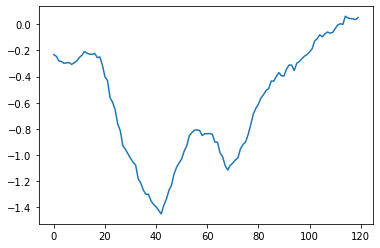

In [11]:
plt.plot(x[:, 2])

# 모델 생성

StackedLSTM Bidirectional

In [12]:
model = utils.BaselineLSTM(input_size=6,
                           hidden_size=64,
                           num_layers=8,
                           dropout=0.2,
                           bidirectional=True).cuda()

In [13]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [14]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [15]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [16]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [17]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.675684
 - Pitch        :  11.882710
 - Roll         :   3.090624
 - RMS          :   9.025328
 - 99% Tile     :  43.330399
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0001.npy


[0003/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.237399
 - Pitch        :   9.077845
 - Roll         :   3.084725
 - RMS          :   7.686619
 - 99% Tile     :  40.773782
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0002.npy


[0004/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.537920
 - Pitch        :   7.938986
 - Roll         :   3.088405
 - RMS          :   7.383262
 - 99% Tile     :  38.824084
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0003.npy


[0005/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   8.355553
 - Pitch        :   7.407341
 - Roll         :   3.052545
 - RMS          :   6.683362
 - 99% Tile     :  34.717503
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0004.npy


[0006/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.543623
 - Pitch        :   6.694583
 - Roll         :   2.988456
 - RMS          :   5.306602
 - 99% Tile     :  32.234639
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0005.npy


[0007/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.309098
 - Pitch        :   4.898234
 - Roll         :   2.937449
 - RMS          :   4.130764
 - 99% Tile     :  29.168844
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0006.npy


[0008/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.464226
 - Pitch        :   3.848154
 - Roll         :   2.867957
 - RMS          :   3.417325
 - 99% Tile     :  26.498051
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0007.npy


[0009/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.018285
 - Pitch        :   3.162340
 - Roll         :   2.845443
 - RMS          :   3.011477
 - 99% Tile     :  24.249219
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0008.npy


[0010/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.733143
 - Pitch        :   2.879727
 - Roll         :   2.880213
 - RMS          :   2.831873
 - 99% Tile     :  21.974836
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0009.npy


[0011/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.415987
 - Pitch        :   2.484697
 - Roll         :   2.862357
 - RMS          :   2.595111
 - 99% Tile     :  19.984699
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0010.npy


[0012/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.414919
 - Pitch        :   2.149678
 - Roll         :   2.852673
 - RMS          :   2.489357
 - 99% Tile     :  18.957480
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0011.npy


[0013/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.057853
 - Pitch        :   2.020837
 - Roll         :   2.804411
 - RMS          :   2.322589
 - 99% Tile     :  18.340135
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0012.npy


[0014/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.865281
 - Pitch        :   1.819246
 - Roll         :   2.842814
 - RMS          :   2.226396
 - 99% Tile     :  17.279836
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0013.npy


[0015/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.804086
 - Pitch        :   1.676305
 - Roll         :   2.857406
 - RMS          :   2.177881
 - 99% Tile     :  17.048852
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0014.npy


[0016/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.708716
 - Pitch        :   1.637160
 - Roll         :   2.836380
 - RMS          :   2.132687
 - 99% Tile     :  16.598174
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0015.npy


[0017/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.738426
 - Pitch        :   1.534154
 - Roll         :   2.804198
 - RMS          :   2.100736
 - 99% Tile     :  16.716192
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0016.npy


[0018/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.742471
 - Pitch        :   1.608811
 - Roll         :   2.814945
 - RMS          :   2.125119
 - 99% Tile     :  16.617913
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0017.npy


[0019/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.655147
 - Pitch        :   1.478546
 - Roll         :   2.754740
 - RMS          :   2.042401
 - 99% Tile     :  16.039368
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0018.npy


[0020/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.665189
 - Pitch        :   1.451310
 - Roll         :   2.787422
 - RMS          :   2.053361
 - 99% Tile     :  16.182310
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0019.npy


[0021/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.972298
 - Pitch        :   1.441943
 - Roll         :   2.700581
 - RMS          :   2.102561
 - 99% Tile     :  16.008241
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0020.npy


[0022/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.484693
 - Pitch        :   1.441779
 - Roll         :   2.460956
 - RMS          :   1.856461
 - 99% Tile     :  15.650167
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0021.npy


[0023/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.523832
 - Pitch        :   1.483847
 - Roll         :   2.144564
 - RMS          :   1.743848
 - 99% Tile     :  15.160937
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0022.npy


[0024/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.680864
 - Pitch        :   1.374589
 - Roll         :   1.877499
 - RMS          :   1.657287
 - 99% Tile     :  14.620495
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0023.npy


[0025/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.133611
 - Pitch        :   1.260203
 - Roll         :   1.858982
 - RMS          :   1.452469
 - 99% Tile     :  15.313946
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0024.npy


[0026/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.136902
 - Pitch        :   1.197077
 - Roll         :   1.746074
 - RMS          :   1.387361
 - 99% Tile     :  14.885081
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0025.npy


[0027/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.120180
 - Pitch        :   1.176229
 - Roll         :   1.599206
 - RMS          :   1.316026
 - 99% Tile     :  13.878967
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0026.npy


[0028/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.195984
 - Pitch        :   1.168924
 - Roll         :   1.574848
 - RMS          :   1.326261
 - 99% Tile     :  13.447673
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0027.npy


[0029/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.109365
 - Pitch        :   1.146031
 - Roll         :   1.385653
 - RMS          :   1.219852
 - 99% Tile     :  11.903960
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0028.npy


[0030/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.283575
 - Pitch        :   1.153078
 - Roll         :   1.346191
 - RMS          :   1.263511
 - 99% Tile     :  11.394156
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0029.npy


[0031/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.197276
 - Pitch        :   1.235210
 - Roll         :   1.302054
 - RMS          :   1.245600
 - 99% Tile     :  10.965890
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0030.npy


[0032/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.082811
 - Pitch        :   1.169679
 - Roll         :   1.306736
 - RMS          :   1.189984
 - 99% Tile     :  10.908824
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0031.npy


[0033/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.133358
 - Pitch        :   1.186517
 - Roll         :   1.280823
 - RMS          :   1.201781
 - 99% Tile     :  10.932090
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0032.npy


[0034/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.389858
 - Pitch        :   1.426989
 - Roll         :   1.273956
 - RMS          :   1.365158
 - 99% Tile     :  10.795893
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0033.npy


[0035/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.131488
 - Pitch        :   1.193812
 - Roll         :   1.303693
 - RMS          :   1.211757
 - 99% Tile     :  11.104292
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0034.npy


[0036/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.241322
 - Pitch        :   1.121502
 - Roll         :   1.162761
 - RMS          :   1.176245
 - 99% Tile     :  10.669862
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0035.npy


[0037/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.168976
 - Pitch        :   1.213256
 - Roll         :   1.191884
 - RMS          :   1.191509
 - 99% Tile     :  10.384249
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0036.npy


[0038/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.275206
 - Pitch        :   1.204931
 - Roll         :   1.259708
 - RMS          :   1.246980
 - 99% Tile     :  10.478259
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0037.npy


[0039/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.233961
 - Pitch        :   1.219101
 - Roll         :   1.173684
 - RMS          :   1.209187
 - 99% Tile     :  10.612525
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0038.npy


[0040/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.137436
 - Pitch        :   1.277610
 - Roll         :   1.156157
 - RMS          :   1.192022
 - 99% Tile     :  10.597068
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0039.npy


[0041/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.145148
 - Pitch        :   1.303800
 - Roll         :   1.097054
 - RMS          :   1.185297
 - 99% Tile     :  10.154769
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0040.npy


[0042/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.058025
 - Pitch        :   1.245886
 - Roll         :   1.081016
 - RMS          :   1.131407
 - 99% Tile     :   9.644538
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0041.npy


[0043/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.112957
 - Pitch        :   1.153895
 - Roll         :   1.069073
 - RMS          :   1.112514
 - 99% Tile     :  10.158812
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0042.npy


[0044/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.035913
 - Pitch        :   1.192567
 - Roll         :   1.149721
 - RMS          :   1.128006
 - 99% Tile     :   9.898067
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0043.npy


[0045/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.064732
 - Pitch        :   1.185078
 - Roll         :   1.012917
 - RMS          :   1.089964
 - 99% Tile     :   9.740905
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0044.npy


[0046/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.007969
 - Pitch        :   1.145753
 - Roll         :   1.043019
 - RMS          :   1.067183
 - 99% Tile     :   9.532128
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0045.npy


[0047/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.115442
 - Pitch        :   1.208705
 - Roll         :   1.065828
 - RMS          :   1.131543
 - 99% Tile     :   9.856113
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0046.npy


[0048/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.951159
 - Pitch        :   1.128557
 - Roll         :   1.033550
 - RMS          :   1.040284
 - 99% Tile     :   9.877420
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0047.npy


[0049/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.966671
 - Pitch        :   1.076864
 - Roll         :   0.991677
 - RMS          :   1.012836
 - 99% Tile     :   9.817868
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0048.npy


[0050/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.011686
 - Pitch        :   1.129986
 - Roll         :   0.975755
 - RMS          :   1.041230
 - 99% Tile     :   9.948763
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0049.npy


[0051/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.080404
 - Pitch        :   1.218038
 - Roll         :   0.962590
 - RMS          :   1.092012
 - 99% Tile     :   9.760735
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0050.npy


[0052/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.027964
 - Pitch        :   1.106482
 - Roll         :   0.964800
 - RMS          :   1.034706
 - 99% Tile     :   9.748543
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0051.npy


[0053/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.227907
 - Pitch        :   1.180965
 - Roll         :   0.952994
 - RMS          :   1.127036
 - 99% Tile     :   9.547099
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0052.npy


[0054/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.963632
 - Pitch        :   1.071036
 - Roll         :   1.022503
 - RMS          :   1.020003
 - 99% Tile     :   9.311231
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0053.npy


[0055/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.985176
 - Pitch        :   1.092307
 - Roll         :   0.959711
 - RMS          :   1.014027
 - 99% Tile     :   9.855141
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0054.npy


[0056/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.040003
 - Pitch        :   1.058015
 - Roll         :   0.926821
 - RMS          :   1.009951
 - 99% Tile     :   9.400958
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0055.npy


[0057/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.060001
 - Pitch        :   1.067906
 - Roll         :   0.951557
 - RMS          :   1.027860
 - 99% Tile     :   9.680879
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0056.npy


[0058/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.954980
 - Pitch        :   1.145352
 - Roll         :   0.930911
 - RMS          :   1.014957
 - 99% Tile     :   9.504854
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0057.npy


[0059/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.029135
 - Pitch        :   1.069731
 - Roll         :   0.940853
 - RMS          :   1.014667
 - 99% Tile     :   9.467459
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0058.npy


[0060/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.993446
 - Pitch        :   1.141767
 - Roll         :   0.916327
 - RMS          :   1.021473
 - 99% Tile     :   9.575578
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0059.npy


[0061/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.960234
 - Pitch        :   1.087309
 - Roll         :   0.913783
 - RMS          :   0.989830
 - 99% Tile     :   9.331860
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0060.npy


[0062/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.953067
 - Pitch        :   1.102299
 - Roll         :   0.921565
 - RMS          :   0.995436
 - 99% Tile     :   9.573233
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0061.npy


[0063/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.989400
 - Pitch        :   1.111124
 - Roll         :   0.923319
 - RMS          :   1.010945
 - 99% Tile     :   9.684083
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0062.npy


[0064/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.002139
 - Pitch        :   1.108351
 - Roll         :   0.920798
 - RMS          :   1.013343
 - 99% Tile     :   9.344184
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0063.npy


[0065/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.979728
 - Pitch        :   1.058461
 - Roll         :   0.921965
 - RMS          :   0.988303
 - 99% Tile     :   9.750932
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0064.npy


[0066/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.963394
 - Pitch        :   1.067673
 - Roll         :   0.931800
 - RMS          :   0.989327
 - 99% Tile     :   9.583316
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0065.npy


[0067/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.964215
 - Pitch        :   1.105343
 - Roll         :   0.933030
 - RMS          :   1.003666
 - 99% Tile     :   9.577519
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0066.npy


[0068/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.965781
 - Pitch        :   1.048092
 - Roll         :   0.913726
 - RMS          :   0.977433
 - 99% Tile     :   9.657733
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0067.npy


[0069/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.004317
 - Pitch        :   1.045936
 - Roll         :   0.933196
 - RMS          :   0.995572
 - 99% Tile     :   9.527583
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0068.npy


[0070/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.975217
 - Pitch        :   1.082985
 - Roll         :   0.913344
 - RMS          :   0.992992
 - 99% Tile     :   9.720254
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0069.npy


[0071/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.956368
 - Pitch        :   1.075498
 - Roll         :   0.962024
 - RMS          :   0.999471
 - 99% Tile     :   9.676021
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0070.npy


[0072/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.915568
 - Pitch        :   1.061714
 - Roll         :   0.949833
 - RMS          :   0.977699
 - 99% Tile     :   9.597210
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0071.npy


[0073/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.936396
 - Pitch        :   1.099990
 - Roll         :   0.932478
 - RMS          :   0.992695
 - 99% Tile     :   9.859367
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0072.npy


[0074/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.986680
 - Pitch        :   1.092329
 - Roll         :   0.937726
 - RMS          :   1.007646
 - 99% Tile     :   9.947850
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0073.npy


[0075/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.960223
 - Pitch        :   1.131125
 - Roll         :   0.917757
 - RMS          :   1.007265
 - 99% Tile     :   9.909423
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0074.npy


[0076/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   0.970106
 - Pitch        :   1.101227
 - Roll         :   0.920703
 - RMS          :   1.000250
 - 99% Tile     :   9.932226
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0075.npy


[0077/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   0.973090
 - Pitch        :   1.134701
 - Roll         :   0.916085
 - RMS          :   1.012203
 - 99% Tile     :   9.869883
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0076.npy


[0078/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   0.996391
 - Pitch        :   1.063850
 - Roll         :   0.924341
 - RMS          :   0.996490
 - 99% Tile     :   9.909778
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0077.npy


[0078/0100] Validation: 100%|██████████████████████| 74/74 [00:05<00:00, 13.62it/s, val_loss 5.7838]


Decaying lr from 0.000125 to 6.25e-05 because val_loss did not improved for 5 epochs
val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   0.971428
 - Pitch        :   1.063127
 - Roll         :   0.927875
 - RMS          :   0.989084
 - 99% Tile     :   9.879134
Save output signals into checkpoint/Scene1-LSTM[Window120]/sample/0078.npy


# 문제점

약 13epoch 정도부터 train과 validation loss의 차이가 커지기 시작함.

학습은 되는데 train/validation의 차이만 커지는 것이기 때문에 일종의 overfit과 같나???  
그럼 depth를 좀 줄여주거나, width를 좀 늘려주는 방법으로 가보자  
dropout 대신에 batchnorm을 써보는 것도?? --> 데이터 자체가 offset이 큰 편이니깐